# Libraries

In [143]:
import numpy as np
import pandas as pd

# metrics

In [144]:
def confusion_matrix(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def accuracy_score(y_true, y_pred):
    return np.mean(np.asarray(y_true) == np.asarray(y_pred))

def precision_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fp = cm[1,1], cm[0,1]
    return tp / (tp + fp) if (tp + fp) else 0

def recall_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fn = cm[1,1], cm[1,0]
    return tp / (tp + fn) if (tp + fn) else 0

def f1_score(y_true, y_pred):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) else 0

def silhouette_score(X, labels):
    X = np.asarray(X)
    labels = np.asarray(labels)
    n = X.shape[0]
    uniq = np.unique(labels)

    D = np.zeros((n, n))
    for i in range(n):
        D[i, i+1:] = np.sum((X[i] - X[i+1:])**2, axis=1)
    D = D + D.T  # Make symmetric
    
    sil = np.zeros(n)
    for label in uniq:
        mask = labels == label
        points_in_cluster = np.where(mask)[0]
        
        if len(points_in_cluster) <= 1:
            continue
            
        a_values = np.zeros(len(points_in_cluster))
        for i, idx in enumerate(points_in_cluster):
            a_values[i] = np.mean(D[idx, points_in_cluster[points_in_cluster != idx]])
        
        b_values = np.ones(len(points_in_cluster)) * np.inf
        for other_label in uniq:
            if other_label == label:
                continue
                
            other_mask = labels == other_label
            other_points = np.where(other_mask)[0]
            
            if len(other_points) == 0:
                continue
                
            for i, idx in enumerate(points_in_cluster):
                mean_dist = np.mean(D[idx, other_points])
                b_values[i] = min(b_values[i], mean_dist)
        
        sil_values = (b_values - a_values) / np.maximum(a_values, b_values)
        sil[points_in_cluster] = sil_values
        
    return np.mean(sil)

# class MyPCA

In [145]:
class MyPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X):
        # 1) Tâm dữ liệu
        self.mean_ = np.mean(X, axis=0)
        Xc = X - self.mean_
        # 2) Ma trận hiệp phương sai
        n_samples = X.shape[0]
        if X.shape[0] > 10000:
            # phong truong hop du lieu lon
            chunk_size = 1000
            C = np.zeros((X.shape[1], X.shape[1]))
            for i in range(0, n_samples, chunk_size):
                end = min(i + chunk_size, n_samples)
                chunk = Xc[i:end]
                C += np.dot(chunk.T, chunk)
            C /= (n_samples - 1)
        else:
            C = np.dot(Xc.T, Xc) / (n_samples - 1)
        # 3) Tính trị riêng và vector riêng
        eigvals, eigvecs = np.linalg.eigh(C)
        # 4) Sắp xếp giảm dần
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        # 5) Chọn số thành phần
        if self.n_components is not None:
            eigvals = eigvals[:self.n_components]
            eigvecs = eigvecs[:, :self.n_components]
        # 6) Lưu kết quả
        self.components_ = eigvecs.T
        self.explained_variance_ = eigvals
        self.total_var_ = np.sum(np.linalg.eigvalsh(C))  # Total variance
        self.explained_variance_ratio_ = eigvals / self.total_var_
        self.cumulative_explained_variance_ = np.cumsum(self.explained_variance_ratio_)

        return self

    def transform(self, X):
        Xc = X - self.mean_

        return np.dot(Xc, self.components_.T)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# KMeans

In [146]:
def kmeans(X, k=2, max_iters=100, tol=1e-6, n_init=10, init_method='kmeans++', random_state=None, early_stopping_iter=5, batch_size=None):
    n_samples, n_features = X.shape
    rng = np.random.RandomState(random_state) if random_state is not None else np.random
    
    # Optimize batch size
    if batch_size is None:
        batch_size = min(1000, n_samples)
    
    best_inertia = float('inf')
    best_labels = None
    best_centers = None
    
    # Pre-allocate distance matrix
    distances = np.zeros((min(batch_size, n_samples), k))
    
    for init_attempt in range(n_init):
        # Initialize centers
        if init_method == 'kmeans++':
            centers = np.zeros((k, n_features))
            # First center randomly
            idx = rng.choice(n_samples)
            centers[0] = X[idx].copy()
            
            # Choose remaining centers
            for i in range(1, k):
                # Calculate minimum distances to existing centers
                min_dists = np.zeros(n_samples)
                for j in range(n_samples):
                    min_dist = float('inf')
                    for c in range(i):
                        dist = np.sum((X[j] - centers[c])**2)
                        if dist < min_dist:
                            min_dist = dist
                    min_dists[j] = min_dist
                
                # Choose next center with probability proportional to distance squared
                sum_dists = np.sum(min_dists)
                if sum_dists > 0:
                    probs = min_dists / sum_dists
                    idx = rng.choice(n_samples, p=probs)
                else:
                    idx = rng.choice(n_samples)
                
                centers[i] = X[idx].copy()
        else:
            # Random initialization
            indices = rng.choice(n_samples, size=k, replace=False)
            centers = X[indices].copy()
        
        # EM optimization
        labels = np.zeros(n_samples, dtype=int)
        prev_inertias = []
        
        for iteration in range(max_iters):
            # Process in batches for large datasets
            changed = False
            inertia = 0
            
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_indices = np.arange(start, end)
                X_batch = X[batch_indices]
                batch_size_actual = end - start
                
                # Calculate distances efficiently
                for i in range(k):
                    distances[:batch_size_actual, i] = np.sum((X_batch - centers[i])**2, axis=1)
                
                # Update labels
                new_labels = np.argmin(distances[:batch_size_actual], axis=1)
                if not np.array_equal(labels[batch_indices], new_labels):
                    changed = True
                    labels[batch_indices] = new_labels
                
                # Calculate partial inertia
                for i in range(k):
                    cluster_points = X_batch[new_labels == i]
                    if len(cluster_points) > 0:
                        inertia += np.sum((cluster_points - centers[i])**2)
            
            # Check for empty clusters and handle them
            cluster_sizes = np.bincount(labels, minlength=k)
            empty_clusters = np.where(cluster_sizes == 0)[0]
            
            if len(empty_clusters) > 0:
                for empty_idx in empty_clusters:
                    # Find largest cluster
                    largest_idx = np.argmax(cluster_sizes)
                    if cluster_sizes[largest_idx] <= 1:
                        continue
                    
                    # Find point in largest cluster farthest from its center
                    mask = labels == largest_idx
                    points = X[mask]
                    center = centers[largest_idx]
                    distances_to_center = np.sum((points - center)**2, axis=1)
                    farthest_idx = np.argmax(distances_to_center)
                    
                    # Get original index and reassign
                    orig_idx = np.where(mask)[0][farthest_idx]
                    labels[orig_idx] = empty_idx
                    
                    # Update cluster sizes
                    cluster_sizes[empty_idx] += 1
                    cluster_sizes[largest_idx] -= 1
            
            # Update centers
            new_centers = np.zeros_like(centers)
            for i in range(k):
                mask = labels == i
                if np.any(mask):
                    new_centers[i] = np.mean(X[mask], axis=0)
                else:
                    new_centers[i] = centers[i]
            
            # Check convergence
            center_shift = np.sum((centers - new_centers)**2)
            centers = new_centers
            
            # Early stopping
            prev_inertias.append(inertia)
            if len(prev_inertias) > early_stopping_iter:
                recent_improvements = np.diff(prev_inertias[-early_stopping_iter:])
                if np.all(np.abs(recent_improvements) < tol * inertia) or not changed:
                    break
            
            if center_shift < tol:
                break
        
        # Keep best result
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
            best_centers = centers.copy()
    
    return best_labels, best_centers, best_inertia

# Agglomerative

In [147]:
def agglomerative_mst(X, k):
    n = X.shape[0]
    
    # Use more memory-efficient distance calculation
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            D[i, j] = np.sum((X[i] - X[j])**2)
            D[j, i] = D[i, j]  # Symmetric
    
    # Optimized Prim's algorithm
    in_mst = np.zeros(n, bool)
    in_mst[0] = True
    edge_weights = D[0].copy()  # Distances from first node
    parent = np.zeros(n, int)
    edges = []
    
    # Use heap for more efficient minimum finding
    import heapq
    heap = [(edge_weights[i], 0, i) for i in range(1, n)]
    heapq.heapify(heap)
    
    while heap:
        weight, src, dst = heapq.heappop(heap)
        if in_mst[dst]:
            continue
            
        # Add edge to MST
        edges.append((src, dst, weight))
        in_mst[dst] = True
        
        # Update heap with new edges
        for j in range(n):
            if not in_mst[j] and D[dst, j] < edge_weights[j]:
                edge_weights[j] = D[dst, j]
                parent[j] = dst
                heapq.heappush(heap, (D[dst, j], dst, j))
    
    # Sort edges by weight (descending)
    edges.sort(key=lambda e: e[2], reverse=True)
    
    # Create adjacency list excluding k-1 heaviest edges
    adj = [[] for _ in range(n)]
    for u, v, w in edges[k-1:]:
        adj[u].append(v)
        adj[v].append(u)
    
    # Use efficient connected components labeling
    labels = np.full(n, -1, dtype=int)
    cid = 0
    
    for i in range(n):
        if labels[i] >= 0:
            continue
            
        # BFS for connected component
        labels[i] = cid
        queue = [i]
        idx = 0
        
        while idx < len(queue):
            node = queue[idx]
            idx += 1
            
            for neighbor in adj[node]:
                if labels[neighbor] < 0:
                    labels[neighbor] = cid
                    queue.append(neighbor)
        
        cid += 1
    
    return labels

# preprocess

In [148]:
def preprocessing(X, scaling="robust"):
    if scaling == "robust":
        # Handle missing values
        missing_mask = np.isnan(X)
        if np.any(missing_mask):
            col_medians = np.nanmedian(X, axis=0)
            X = np.copy(X)  # Avoid modifying original
            for col in range(X.shape[1]):
                X[missing_mask[:, col], col] = col_medians[col]
        
        # Handle outliers with vectorized operations
        q1 = np.percentile(X, 25, axis=0)
        q3 = np.percentile(X, 75, axis=0)
        iqr = q3 - q1
        lower_bounds = q1 - 1.5 * iqr  # Less aggressive outlier threshold
        upper_bounds = q3 + 1.5 * iqr
        
        X_clean = np.clip(X, lower_bounds, upper_bounds)
        
        # Robust scaling
        medians = np.median(X_clean, axis=0)
        iqrs = np.percentile(X_clean, 75, axis=0) - np.percentile(X_clean, 25, axis=0)
        
        # Avoid division by zero
        iqrs = np.where(iqrs > 0, iqrs, 1.0)
        X_scaled = (X_clean - medians) / iqrs
        
        return X_scaled
    
    elif scaling == 'standard':
        # Implement standard scaling directly
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        std = np.where(std > 0, std, 1.0)  # Avoid division by zero
        return (X - mean) / std
    
    return X  

# feature selection

In [149]:
# Enhanced feature selection with improved correlation handling
def feature_selection(X, threshold=0.7):
    # Calculate variances
    variances = np.var(X, axis=0)
    
    # Apply variance threshold (more robust)
    var_threshold = threshold * np.median(variances)  # Adaptive threshold
    high_var_mask = variances > var_threshold
    
    if np.sum(high_var_mask) <= 1:
        return X, high_var_mask
    
    X_filtered = X[:, high_var_mask]
    original_indices = np.where(high_var_mask)[0]
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(X_filtered.T)
    np.fill_diagonal(corr_matrix, 0)  # Zero out diagonal
    
    # Find highly correlated features
    to_drop = set()
    
    # Sort features by variance (descending)
    var_order = np.argsort(variances[high_var_mask])[::-1]
    
    # Keep higher variance features when high correlation exists
    for i in range(len(var_order)):
        if i in to_drop:
            continue
            
        idx = var_order[i]
        correlated = np.where(np.abs(corr_matrix[idx]) > threshold)[0]
        
        # Remove highly correlated features with lower variance
        for j in correlated:
            if j != idx and j not in to_drop:
                to_drop.add(j)
    
    # Create final mask
    keep_mask = np.ones(len(original_indices), dtype=bool)
    keep_mask[list(to_drop)] = False
    
    final_indices = original_indices[keep_mask]
    final_mask = np.zeros(X.shape[1], dtype=bool)
    final_mask[final_indices] = True
    
    return X[:, final_mask], final_mask

# visualize functions

In [150]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse

def visualization(X_pca, labels, true_labels=None, title="PCA Visualization", show_centers=True, alpha=0.7):
    n_components = X_pca.shape[1]
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # Set up color palette
    palette = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    cluster_colors = ListedColormap(palette)
    
    # Create figure based on number of components
    if n_components >= 3:
        # 3D visualization
        if true_labels is not None:
            fig = plt.figure(figsize=(18, 10))
            gs = gridspec.GridSpec(1, 2)
            
            # Plot clustering results
            ax1 = fig.add_subplot(gs[0], projection='3d')
            scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                      c=labels, cmap=cluster_colors, marker='o', s=40, alpha=alpha, edgecolors='w', linewidth=0.5)
            ax1.set_title("Clustering Results", fontsize=14, fontweight='bold')
            ax1.set_xlabel('PC1', fontsize=12)
            ax1.set_ylabel('PC2', fontsize=12)
            ax1.set_zlabel('PC3', fontsize=12)
            
            # Add legend
            handles, _ = scatter1.legend_elements()
            ax1.legend(handles, [f'Cluster {i}' for i in unique_labels], 
                      title="Clusters", loc='upper right', fontsize=10)
            
            # Add cluster centers if requested
            if show_centers:
                for label in unique_labels:
                    cluster_points = X_pca[labels == label]
                    center = np.mean(cluster_points, axis=0)
                    ax1.scatter(center[0], center[1], center[2], 
                               s=200, marker='X', color='red', 
                               edgecolors='black', linewidth=1.5)
            
            # Plot true labels
            ax2 = fig.add_subplot(gs[1], projection='3d')
            unique_true = np.unique(true_labels)
            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                      c=true_labels, cmap=cluster_colors, marker='o', s=40, alpha=alpha, edgecolors='w', linewidth=0.5)
            ax2.set_title("True Labels", fontsize=14, fontweight='bold')
            ax2.set_xlabel('PC1', fontsize=12)
            ax2.set_ylabel('PC2', fontsize=12)
            ax2.set_zlabel('PC3', fontsize=12)
            
            # Add true labels legend
            handles, _ = scatter2.legend_elements()
            ax2.legend(handles, [f'Class {i}' for i in unique_true], 
                      title="Classes", loc='upper right', fontsize=10)
            
        else:
            # Simple 3D plot without true labels
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                      c=labels, cmap=cluster_colors, marker='o', s=40, alpha=alpha, edgecolors='w', linewidth=0.5)
            
            # Add legend
            handles, _ = scatter.legend_elements()
            ax.legend(handles, [f'Cluster {i}' for i in unique_labels], 
                     title="Clusters", loc='upper right', fontsize=10)
            
            ax.set_xlabel('PC1', fontsize=12)
            ax.set_ylabel('PC2', fontsize=12)
            ax.set_zlabel('PC3', fontsize=12)
            
            # Add cluster centers if requested
            if show_centers:
                for label in unique_labels:
                    cluster_points = X_pca[labels == label]
                    center = np.mean(cluster_points, axis=0)
                    ax.scatter(center[0], center[1], center[2], 
                              s=200, marker='X', color='red', 
                              edgecolors='black', linewidth=1.5)
                    
    else:
        # 2D visualization with more details
        if true_labels is not None:
            fig = plt.figure(figsize=(18, 10))
            gs = gridspec.GridSpec(1, 2)
            
            # Plot clustering results
            ax1 = fig.add_subplot(gs[0])
            scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                       cmap=cluster_colors, marker='o', s=40, alpha=alpha, edgecolors='w', linewidth=0.5)
            ax1.set_title("Clustering Results", fontsize=14, fontweight='bold')
            ax1.set_xlabel('PC1', fontsize=12)
            ax1.set_ylabel('PC2', fontsize=12)
            ax1.grid(True, linestyle='--', alpha=0.7)
            
            # Add cluster ellipses
            for label in unique_labels:
                cluster_points = X_pca[labels == label]
                if len(cluster_points) > 1:  # Need at least 2 points for covariance
                    cov = np.cov(cluster_points.T)
                    center = np.mean(cluster_points, axis=0)
                    
                    # Draw confidence ellipse (95%)
                    draw_confidence_ellipse(center, cov, ax1, n_std=2.0, 
                                          color=plt.cm.tab10(label % 10),
                                          alpha=0.3, label=f'Cluster {label}')
            
            # Add legend for clusters
            handles, _ = scatter1.legend_elements()
            ax1.legend(handles, [f'Cluster {i}' for i in unique_labels], 
                      loc='upper right', title="Clusters", fontsize=10)
            
            # Plot true labels
            ax2 = fig.add_subplot(gs[1])
            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, 
                       cmap=cluster_colors, marker='o', s=40, alpha=alpha, edgecolors='w', linewidth=0.5)
            ax2.set_title("True Labels", fontsize=14, fontweight='bold')
            ax2.set_xlabel('PC1', fontsize=12)
            ax2.set_ylabel('PC2', fontsize=12)
            ax2.grid(True, linestyle='--', alpha=0.7)
            
            # Add true class ellipses
            unique_true = np.unique(true_labels)
            for label in unique_true:
                class_points = X_pca[true_labels == label]
                if len(class_points) > 1:
                    cov = np.cov(class_points.T)
                    center = np.mean(class_points, axis=0)
                    
                    # Draw confidence ellipse (95%)
                    draw_confidence_ellipse(center, cov, ax2, n_std=2.0, 
                                          color=plt.cm.tab10(label % 10),
                                          alpha=0.3, label=f'Class {label}')
            
            # Add legend for true classes
            handles, _ = scatter2.legend_elements()
            ax2.legend(handles, [f'Class {i}' for i in unique_true], 
                      loc='upper right', title="Classes", fontsize=10)
            
        else:
            # Simple 2D plot without true labels
            fig = plt.figure(figsize=(14, 10))
            ax = fig.add_subplot(111)
            scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                      cmap=cluster_colors, marker='o', s=40, alpha=alpha, edgecolors='w', linewidth=0.5)
            
            # Add legend
            handles, _ = scatter.legend_elements()
            ax.legend(handles, [f'Cluster {i}' for i in unique_labels], 
                     loc='upper right', title="Clusters", fontsize=10)
            
            ax.set_xlabel('PC1', fontsize=12)
            ax.set_ylabel('PC2', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Add cluster centers if requested
            if show_centers:
                for label in unique_labels:
                    cluster_points = X_pca[labels == label]
                    center = np.mean(cluster_points, axis=0)
                    ax.scatter(center[0], center[1], s=200, marker='X', color='red', 
                              edgecolors='black', linewidth=1.5)
                    
                    # Draw confidence ellipse for each cluster
                    if len(cluster_points) > 1:
                        cov = np.cov(cluster_points.T)
                        draw_confidence_ellipse(center, cov, ax, n_std=2.0, 
                                              color=plt.cm.tab10(label % 10),
                                              alpha=0.3, label=f'Cluster {label}')
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def draw_confidence_ellipse(center, cov, ax, n_std=2.0, **kwargs):
    # Get eigenvalues and eigenvectors
    if cov.shape == (2, 2):
        try:
            vals, vecs = np.linalg.eigh(cov)
            # Width and height of ellipse
            width, height = 2 * n_std * np.sqrt(vals)
            
            # Angle of the ellipse
            angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
            
            # Create ellipse
            ellipse = Ellipse(xy=center, width=width, height=height, 
                             angle=angle, **kwargs)
            
            ax.add_patch(ellipse)
        except np.linalg.LinAlgError:
            pass  # Skip if covariance is not positive definite


# hàm đánh giá phân cụm

In [151]:
def evaluate_clustering(X, labels, true_labels=None):
    metrics_dict = {}
    
    # Calculate silhouette score
    metrics_dict['silhouette'] = silhouette_score(X, labels)
    
    # Calculate Davies-Bouldin index
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters > 1:
        # Calculate cluster centers
        centers = np.array([np.mean(X[labels == label], axis=0) for label in unique_labels])
        
        # Calculate average distances and cluster separation
        db_values = np.zeros(n_clusters)
        
        for i in range(n_clusters):
            cluster_i = X[labels == unique_labels[i]]
            if len(cluster_i) == 0:
                continue
                
            # Calculate cluster diameter (average distance to center)
            diam_i = np.mean(np.sqrt(np.sum((cluster_i - centers[i])**2, axis=1)))
            
            # Find maximum ratio with other clusters
            max_ratio = 0
            for j in range(n_clusters):
                if i == j:
                    continue
                    
                cluster_j = X[labels == unique_labels[j]]
                if len(cluster_j) == 0:
                    continue
                    
                diam_j = np.mean(np.sqrt(np.sum((cluster_j - centers[j])**2, axis=1)))
                dist_ij = np.sqrt(np.sum((centers[i] - centers[j])**2))
                
                if dist_ij > 0:
                    ratio = (diam_i + diam_j) / dist_ij
                    max_ratio = max(max_ratio, ratio)
            
            db_values[i] = max_ratio
        
        metrics_dict['davies_bouldin'] = np.mean(db_values)
    else:
        metrics_dict['davies_bouldin'] = -1
    
    # Calculate external metrics if true labels provided
    if true_labels is not None:
        # Handle binary classification with potential label flipping
        y_pred = np.copy(labels)
        
        if len(np.unique(true_labels)) == 2 and len(np.unique(y_pred)) == 2:
            # Standardize labels to 0/1
            y_true = (true_labels == np.max(true_labels)).astype(int)
            y_pred = (y_pred == np.max(y_pred)).astype(int)
            
            # Check if labels need flipping
            acc = accuracy_score(y_true, y_pred)
            acc_flipped = accuracy_score(y_true, 1 - y_pred)
            
            if acc_flipped > acc:
                y_pred = 1 - y_pred
            
            metrics_dict['accuracy'] = accuracy_score(y_true, y_pred)
            metrics_dict['precision'] = precision_score(y_true, y_pred)
            metrics_dict['recall'] = recall_score(y_true, y_pred)
            metrics_dict['f1'] = f1_score(y_true, y_pred)
            metrics_dict['confusion_matrix'] = confusion_matrix(y_true, y_pred)
        else:
            # Handle multiclass case with cluster matching
            metrics_dict['accuracy'] = -1
            metrics_dict['precision'] = -1
            metrics_dict['recall'] = -1
            metrics_dict['f1'] = -1
            metrics_dict['confusion_matrix'] = np.zeros((2, 2))
    
    return metrics_dict, y_pred if true_labels is not None else labels

# clustering pipeline

In [152]:
def clustering_pipeline(X, y_true=None, n_clusters=2, feature_selection_threshold=0.7, 
                       pca_variance_threshold=0.9, kmeans_max_iters=300, 
                       kmeans_tol=1e-6, kmeans_n_init=20, kmeans_init_method='kmeans++', 
                       kmeans_random_state=42, kmeans_early_stopping_iter=5, 
                       kmeans_batch_size=None):
    print("Starting clustering pipeline...")
    
    # Step 1: Preprocessing - handle outliers and scaling
    print("\nStep 1: Preprocessing...")
    X_preprocessed = preprocessing(X, scaling="robust")  # Changed to robust scaling
    print(f"  Data shape after preprocessing: {X_preprocessed.shape}")
    
    # Step 2: Feature selection - remove correlated and low-variance features
    print("\nStep 2: Feature selection...")
    X_selected, feature_mask = feature_selection(X_preprocessed, threshold=feature_selection_threshold)
    print(f"  Selected {X_selected.shape[1]} features out of {X_preprocessed.shape[1]}")
    
    # Step 3: PCA - find optimal number of components
    print("\nStep 3: Applying PCA...")
    
    # Adaptive sample size for large datasets
    pca_sample_size = min(X_selected.shape[0], 5000)
    if X_selected.shape[0] > pca_sample_size:
        sample_indices = np.random.choice(X_selected.shape[0], pca_sample_size, replace=False)
        X_pca_sample = X_selected[sample_indices]
        pca = MyPCA()
        pca.fit(X_pca_sample)
    else:
        pca = MyPCA()
        pca.fit(X_selected)
    
    # Efficient component selection using explained variance
    cumulative_var = pca.cumulative_explained_variance_
    n_components_by_var = np.searchsorted(cumulative_var, pca_variance_threshold) + 1
    n_components_by_var = min(n_components_by_var, X_selected.shape[1])
    
    # Dynamic range for silhouette test to find optimal components
    max_components = min(50, X_selected.shape[1], n_components_by_var * 2)
    step_size = max(1, max_components // 10)
    component_range = list(range(2, max_components + 1, step_size))
    
    # Ensure we test variance threshold derived component count
    if n_components_by_var not in component_range:
        component_range.append(n_components_by_var)
        component_range.sort()
    
    # Find optimal components by silhouette score
    print(f"  Testing {len(component_range)} different component counts...")
    best_sil = -10
    best_n = 2
    
    # Try different component counts and choose best by silhouette
    for n in component_range:
        X_tmp = MyPCA(n_components=n).fit_transform(X_selected)
        
        # Quick KMeans for silhouette testing
        labels_tmp, _, _ = kmeans(
            X_tmp, k=n_clusters, 
            max_iters=50,  # Reduced iterations for testing
            n_init=3,      # Fewer initializations for testing
            random_state=kmeans_random_state
        )
        
        sil_tmp = silhouette_score(X_tmp, labels_tmp)
        acc_tmp = accuracy_score(y_true, labels_tmp)
        print(f"    Components: {n}, Silhouette: {sil_tmp:.4f}, Accuracy: {acc_tmp:.4f}")
        
        if sil_tmp > best_sil:
            best_sil, best_n = sil_tmp, n
    
    n_components = min(best_n, int(0.95 * X_selected.shape[1]))
    print(f"  Optimal PCA components: {n_components} (silhouette={best_sil:.4f})")
    
    # Final PCA transformation
    pca = MyPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_selected)
    
    # Step 4: Run multiple clustering algorithms
    print("\nStep 4: Comparing clustering methods...")
    methods = {}
    
    # K-means clustering
    labels_k, centers_k, inertia_k = kmeans(
        X_pca, k=n_clusters,
        max_iters=kmeans_max_iters, 
        tol=kmeans_tol,
        n_init=kmeans_n_init, 
        init_method=kmeans_init_method,
        random_state=kmeans_random_state,
        early_stopping_iter=kmeans_early_stopping_iter,
        batch_size=kmeans_batch_size
    )
    sil_k = silhouette_score(X_pca, labels_k)
    print(f"  KMeans silhouette = {sil_k:.4f}")
    methods['kmeans'] = (labels_k, sil_k)
    
    # Agglomerative clustering
    labels_agg = agglomerative_mst(X_pca, k=n_clusters)
    sil_agg = silhouette_score(X_pca, labels_agg)
    print(f"  Agglomerative-MST silhouette = {sil_agg:.4f}")
    methods['agglomerative'] = (labels_agg, sil_agg)
    
    # Try a hybrid approach - initialize K-means with agglomerative results
    centers_hybrid = np.array([np.mean(X_pca[labels_agg == i], axis=0) 
                              for i in range(n_clusters)])
    labels_hybrid, _, _ = kmeans(
        X_pca, k=n_clusters,
        max_iters=kmeans_max_iters,
        tol=kmeans_tol,
        n_init=1,  # Only one initialization with agglomerative centers
        init_method='custom',
        random_state=kmeans_random_state
    )
    sil_hybrid = silhouette_score(X_pca, labels_hybrid)
    print(f"  Hybrid (Agg+KMeans) silhouette = {sil_hybrid:.4f}")
    methods['hybrid'] = (labels_hybrid, sil_hybrid)
    
    # Select best method
    best_method = max(methods, key=lambda m: methods[m][1])
    best_labels = methods[best_method][0]
    best_sil = methods[best_method][1]
    print(f"  => Selected {best_method} with silhouette = {best_sil:.4f}")
    
    # Evaluate final clustering
    best_metrics, best_labels = evaluate_clustering(X_pca, best_labels, y_true)

    print("\nStep 5: Visualization...")
    visualization(X_pca, best_labels, y_true,
                  title=f"PCA Visualization with {n_components} Components")
    
    # Print final metrics
    print("\nFinal Results:")
    print(f"Algorithm: {best_method}")
    print(f"Number of PCA components: {n_components}")
    for metric, value in best_metrics.items():
        if metric != 'confusion_matrix':
            print(f"{metric}: {value:.4f}")
    
    if y_true is not None:
        print("Confusion Matrix:")
        print(best_metrics['confusion_matrix'])
    
    return best_method, best_labels, best_metrics, n_components, X_pca, feature_mask

# Chuẩn bị dữ liệu

In [153]:
df = pd.read_csv('../data/ABIDE2.csv')

In [154]:
print(f"Kích thước dataset: {df.shape}")
print(f"Số lượng mỗi nhóm:")
print(df['group'].value_counts())

Kích thước dataset: (1004, 1445)
Số lượng mỗi nhóm:
group
Normal    541
Cancer    463
Name: count, dtype: int64


In [155]:
# Assume these columns are not used for clustering
X = df.drop(columns=['site', 'subject', 'group']).values
y = df['group'].values

# Convert labels to numeric (0: Normal, 1: Cancer)
y_numeric = np.where(y == 'Cancer', 1, 0)

# Tìm các tham số tối ưu

Starting clustering pipeline...

Step 1: Preprocessing...
  Data shape after preprocessing: (1004, 1442)

Step 2: Feature selection...
  Selected 419 features out of 1442

Step 3: Applying PCA...
  Testing 11 different component counts...
    Components: 2, Silhouette: 0.6862, Accuracy: 0.4731
    Components: 7, Silhouette: 0.5785, Accuracy: 0.5269
    Components: 12, Silhouette: 0.5455, Accuracy: 0.4731
    Components: 17, Silhouette: 0.5228, Accuracy: 0.5269
    Components: 22, Silhouette: 0.5057, Accuracy: 0.5269
    Components: 27, Silhouette: 0.4914, Accuracy: 0.5269
    Components: 32, Silhouette: 0.4793, Accuracy: 0.5269
    Components: 37, Silhouette: 0.4688, Accuracy: 0.5269
    Components: 42, Silhouette: 0.4597, Accuracy: 0.5269
    Components: 47, Silhouette: 0.4515, Accuracy: 0.5269
    Components: 183, Silhouette: 0.3628, Accuracy: 0.5279
  Optimal PCA components: 2 (silhouette=0.6862)

Step 4: Comparing clustering methods...
  KMeans silhouette = 0.6862
  Agglomerative-M

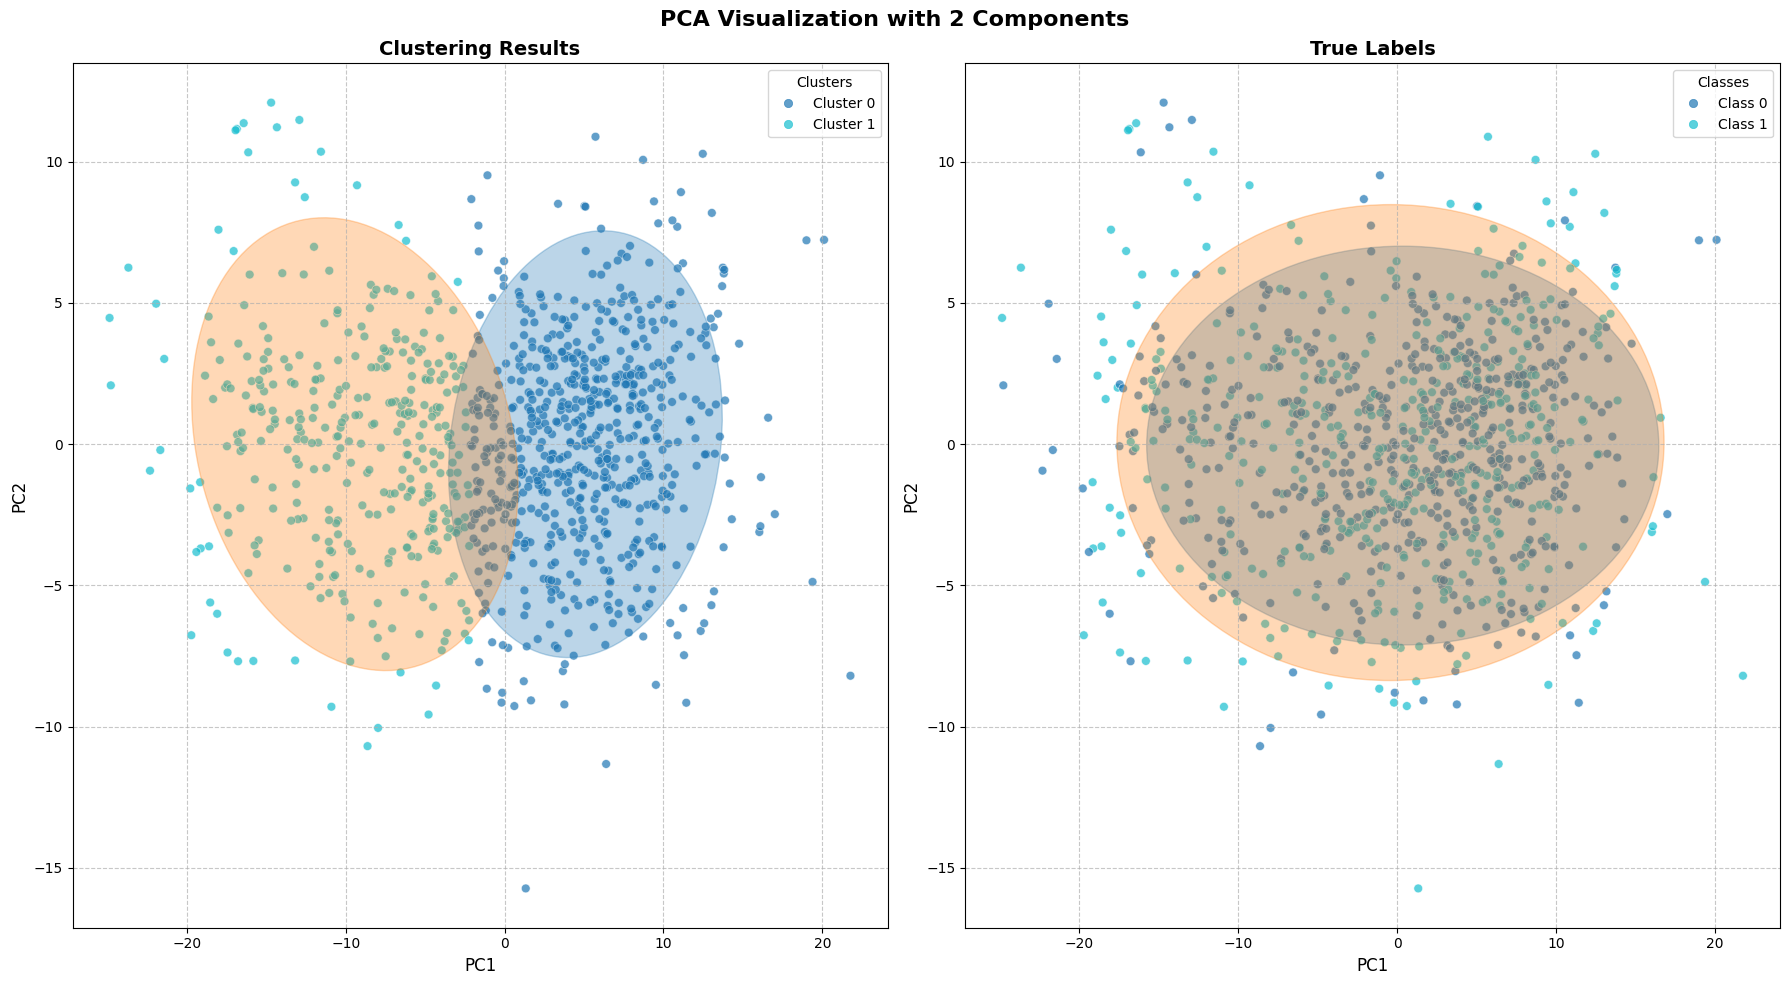


Final Results:
Algorithm: kmeans
Number of PCA components: 2
silhouette: 0.6862
davies_bouldin: 0.7538
accuracy: 0.5269
precision: 0.4830
recall: 0.3672
f1: 0.4172
Confusion Matrix:
[[359 182]
 [293 170]]


In [156]:
# Run the improved clustering pipeline
final_method, final_labels, final_metrics, n_components, X_pca, feature_mask = clustering_pipeline(X, y_numeric, 
                                                                                feature_selection_threshold=0.7, 
                                                                                pca_variance_threshold=0.9, 
                                                                                kmeans_max_iters=300, kmeans_n_init=20
                                                                            )

# Kết quả

In [157]:
# Print final results
print("Final Results:")
print(f'Thuật toán: {final_method}')
print(f"Number of PCA components: {n_components}")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall: {final_metrics['recall']:.4f}")
print(f"F1 score: {final_metrics['f1']:.4f}")
print(f"Silhouette score: {final_metrics['silhouette']:.4f}")


Final Results:
Thuật toán: kmeans
Number of PCA components: 2
Accuracy: 0.5269
Precision: 0.4830
Recall: 0.3672
F1 score: 0.4172
Silhouette score: 0.6862


# So sánh với GMM

In [158]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
labels = gmm.fit_predict(X_pca)
metrics, remapped_labels = evaluate_clustering(X_pca, labels, y_numeric)
print("GMM metrics:")
for metric, value in metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric}: {value}")
print("Confusion Matrix:")
print(metrics['confusion_matrix'])


GMM metrics:
silhouette: 0.6890864537083208
davies_bouldin: 0.741774962593511
accuracy: 0.5398406374501992
precision: 0.5015673981191222
recall: 0.34557235421166305
f1: 0.40920716112531963
Confusion Matrix:
[[382 159]
 [303 160]]
